In [ ]:
# Switching to a different way of processing the annotation files, now that we are labeling "background species" more consistently

In [ ]:
"""
Convert Macaulay Library Annotations to a Standard Format
---------------------------------------------------------

Folks are annotating ML spectrograms and we need to convert the annotations to a more
convenient format. The annotations are stored in normalized coordinates and we need to change 
them to time and frequency coordinates. This requires us to have access to the spectrogram.

ML spectrograms are generated with the following call to SOX

`sox /usr/app/data/audio.mp3 -n trim 0 262 channels 1 rate 20k spectrogram -o /usr/app/data/audio_spec.png -z 80 -m -r -X 250 -y 220`

So the y axis has 220 bins linearly spaced for the 10kHz frequencies and the X axis has 250 pixels per second.

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '9' # don't use a gpu

In [3]:
import csv
import glob
import json
import shutil
import requests
import warnings
import time
import imageio
import librosa
import numpy as np
import pandas as pd
import resampy
from scipy.interpolate import interp1d
from scipy.ndimage import rotate
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt

In [4]:
from object_detection_utils import box_list
from object_detection_utils import box_list_ops

In [1]:
spectrogram_image_dir = '/data/datasets/macaulay/audio_spectrograms_small'
spectrogram_dir = '/data/datasets/macaulay/audio_spectrograms_small'
mp3_dir = '/data/datasets/macaulay/audio_mp3'


MAX_FREQ = 10000
NUM_FREQ_BINS = 220
PIXELS_PER_SECOND = 250.0

y_pixel_to_freq = interp1d([0, NUM_FREQ_BINS],[0, MAX_FREQ])

NameError: name 'interp1d' is not defined

In [5]:
annotation_fps = glob.glob("merlin_audio/ebyb_data/annotations/*.json")
category_fp = "merlin_audio/ebyb_data/categories.json"
ebird_taxonomy_file = '/home/gvanhorn/code/research/bird_detection/ebird_data/eBird_Taxonomy_v2019.csv'

In [6]:
def convert_pixels_to_time(asset_id, annos):
    
    asset_spectrogram_fn = "%s.jpg" % (str(asset_id),)
    asset_spectrogram_fp = os.path.join(spectrogram_image_dir, asset_spectrogram_fn)
    
    if not os.path.exists(asset_spectrogram_fp):
        print("Spectrogram image not available for asset %s" % (str(asset_id),))
        #assert os.path.exists(asset_spectrogram_fp), "Spectrogram image not available for asset %s" % (str(asset_id),)
        return None
    
    spec_image = imageio.imread(asset_spectrogram_fp)
    image_height, image_width = spec_image.shape[:2]
    
    assert image_height == NUM_FREQ_BINS, "The image height should be equal to NUM_FREQ_BINS"
    
    converted_annos = []
    
    for anno in annos:
    
        box = anno['bbox']
        bx, by, bw, bh = box

        time_start_pixel = bx * image_width
        time_stop_pixel = (bx + bw) * image_width
        freq_low_pixel = NUM_FREQ_BINS - ( (by + bh) * image_height )
        freq_high_pixel = NUM_FREQ_BINS - ( by * image_height )

        time_start_sec = time_start_pixel / PIXELS_PER_SECOND
        time_stop_sec = time_stop_pixel / PIXELS_PER_SECOND

        freq_low = float(y_pixel_to_freq(freq_low_pixel))
        freq_high = float(y_pixel_to_freq(freq_high_pixel))
    
        converted_annos.append({
            "image_id" : anno['image_id'],
            "category_id" : anno['category_id'],
            'box_start_sec' : time_start_sec,
            'box_end_sec' : time_stop_sec,
            'box_low_freq' : freq_low,
            'box_high_freq' : freq_high,
        })
    
    return converted_annos
    

In [2]:
# First go through and determine if we need to download any spectrograms or mp3s

total_asset_ids = set()
for annotation_fp in annotation_fps:
    
    with open(annotation_fp) as f:
        annotations = json.load(f)
    
    for anno in annotations:
        total_asset_ids.add(anno['image_id'])

spectrogram_dir = '/data/datasets/macaulay/audio_spectrograms_small'
mp3_dir = '/data/datasets/macaulay/audio_mp3'
    
failed_spectrograms = []
failed_mp3s = []    

for asset_id in total_asset_ids:
    
    spectrogram_fn = "%s.jpg" % (asset_id,)
    spectrogram_fp = os.path.join(spectrogram_dir, spectrogram_fn)
    if not os.path.exists(spectrogram_fp):
        spectrogram_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/%s/spectrogram_small" % (asset_id,)
        try:
            download_image(spectrogram_url, spectrogram_fp)
            print("Downloaded SPEC: %s" % spectrogram_fn)
        except requests.exceptions.RequestException as e: 
            failed_spectrograms.append(asset_id)
        time.sleep(0.2)
        
    mp3_fn = "%s.mp3" % (asset_id,)
    mp3_fp = os.path.join(mp3_dir, mp3_fn)
    if not os.path.exists(mp3_fp):
        mp3_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/%s/audio" % (asset_id,)
        try:
            download_mp3(mp3_url, mp3_fp)
            print("Downloaded MP3: %s" % mp3_fn)
        except requests.exceptions.RequestException as e: 
            failed_mp3s.append(asset_id)
        time.sleep(0.2)

print("Faild to find/download %d spectrograms" % (len(failed_spectrograms),))
print("Faild to find/download %d mp3s" % (len(failed_mp3s),))

NameError: name 'annotation_fps' is not defined

In [8]:
# These are assets that have been deleted on ML or the mp3 has become corrupted or something...
known_bad_assets = [165942921, 25946721]

In [9]:
# Go through and figure out which targets have been annotated
with open(category_fp) as f:
    categories = json.load(f)
all_category_ids = set([cat['id'] for cat in categories])
    
annotated_target_categories = []
for annotation_fp in annotation_fps:
    
    with open(annotation_fp) as f:
        annotations = json.load(f)
    
    # parse out the target category id
    # the filename should be in the form: <target_cat_id>_annotations.json
    target_cat_id = os.path.basename(annotation_fp).split("_")[0]
    
    assert target_cat_id in all_category_ids, "Didn't find %s (from %s) in the list of categories" % (target_cat_id, annotation_fp)
    
    annotated_target_categories.append(target_cat_id)

print("Found %d annotated categories" % (len(annotated_target_categories),))

Found 57 annotated categories


In [ ]:
# Here we could subselect a specific group of categories

In [10]:
# Assign integer labels to the annotated categories
# Use the order of the ebird taxonomy

category_id_to_int_label = {}
category_order = []

with open(ebird_taxonomy_file, encoding='utf-8-sig') as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
        
        species_code = row['SPECIES_CODE']
        if species_code in annotated_target_categories:
            category_id_to_int_label[species_code] = len(category_id_to_int_label)
            category_order.append(species_code)

assert len(category_id_to_int_label) == len(annotated_target_categories), "Didn't find all of the category ids?"

In [11]:
# Load in the train and test splits
test_assets_df = pd.read_csv("merlin_audio/v1/test_assets.csv")
train_assets_df = pd.read_csv("merlin_audio/v1/train_assets.csv")

test_asset_ids = set(test_assets_df['id'].tolist())
train_asset_ids = set(train_assets_df['id'].tolist())

In [12]:
# Go through and process the annotations

annotation_df = pd.DataFrame(columns=[
    'box_start_sec', 
    'box_end_sec',
    'box_high_freq',
    'box_low_freq',
    'asset_id',
    'category_id',
    'label',
    'is_primary'
])

failed_assets = set()
for annotation_fp in annotation_fps:
    
    with open(annotation_fp) as f:
        annotations = json.load(f)
    
    # parse out the target category id
    # the filename should be in the form: <target_cat_id>_annotations.json
    target_cat_id = os.path.basename(annotation_fp).split("_")[0]
    
    # group the annotations by image id
    image_id_to_annos = {}
    for anno in annotations:
        
        # We are only concerned with the target categories at this point
        if anno['category_id'] in annotated_target_categories:
        
            if anno['image_id'] not in image_id_to_annos:
                image_id_to_annos[anno['image_id']] = []
            image_id_to_annos[anno['image_id']].append(anno)
    
    
    for image_id, annos in image_id_to_annos.items():
        
        if image_id in known_bad_assets:
            print("Skipping asset %d because it is known to be bad" % (image_id,))
            continue
        
        split = None
        if image_id in train_asset_ids:
            split = 'train'
        elif image_id in test_asset_ids:
            split = 'test'
        else:
            assert False, "didn't find asset %d in either train or test" % (image_id,)
        
        # convert the pixel normalized annotations to time / frequency
        converted_annos = convert_pixels_to_time(image_id, annos)
        if converted_annos is None:
            failed_assets.add(image_id)
            continue
        
        
        for anno in converted_annos:
            
            # Do some basic sanity checks
            assert anno['box_high_freq'] > anno['box_low_freq'], "weird freq values?"
            assert anno['box_end_sec'] > anno['box_start_sec'], "weird time values?"
            
            annotation_df = annotation_df.append({
                'box_start_sec' : anno['box_start_sec'], 
                'box_end_sec' : anno['box_end_sec'],
                'box_high_freq' : anno['box_high_freq'],
                'box_low_freq' : anno['box_low_freq'],
                'asset_id' : image_id,
                'category_id' : anno['category_id'],
                'label' : category_id_to_int_label[anno['category_id']],
                'is_primary' : anno['category_id'] == target_cat_id,
                'split' : split
            }, ignore_index=True)
        
    

print("Failed to find %d assets" % (len(failed_assets),))
            


Skipping asset 165942921 because it is known to be bad
Failed to find 0 assets


In [13]:
# Here it would be nice to make some visualizations

# Box durations (min, max, average, mean)
# Frequency analysis (min, max, average, mean)
# Box counts
# Histograms, etc. 

box_durs = annotation_df['box_end_sec'] - annotation_df['box_start_sec']

print("Num boxes: %d" % len(box_durs))
print("Min duration: %0.3f" % (np.min(box_durs), ))
print("Max duration: %0.3f" % (np.max(box_durs), ))
print("Mean duration: %0.3f" % (np.mean(box_durs), ))
print("Median duration: %0.3f" % (np.median(box_durs), ))


Num boxes: 33547
Min duration: 0.018
Max duration: 261.953
Mean duration: 1.084
Median duration: 0.427


Text(0.5, 1.0, 'Duration Difference')

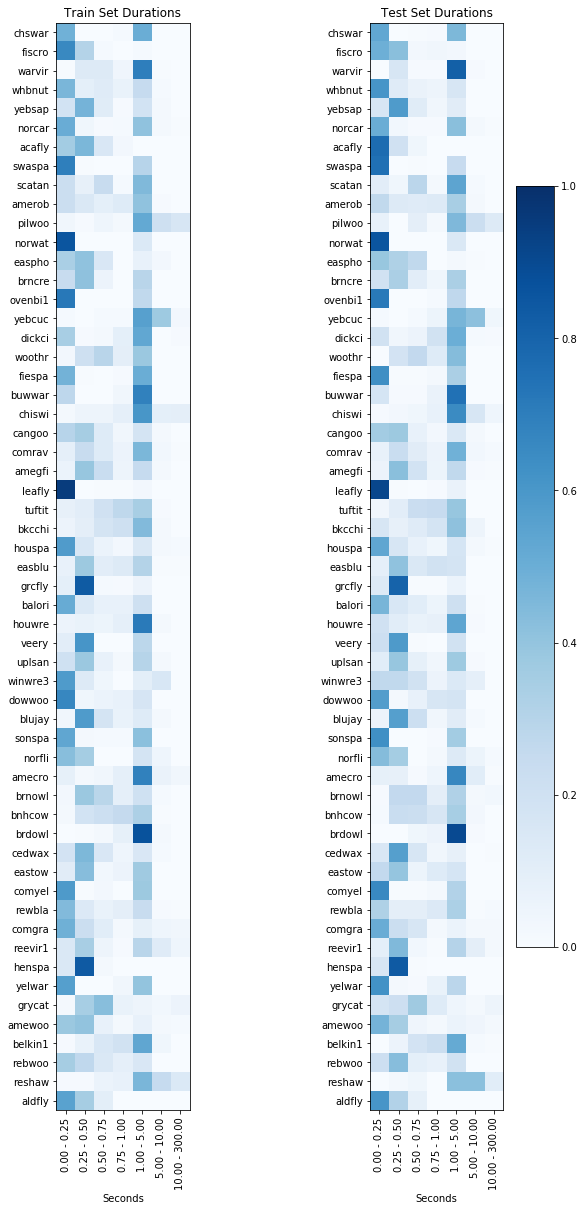

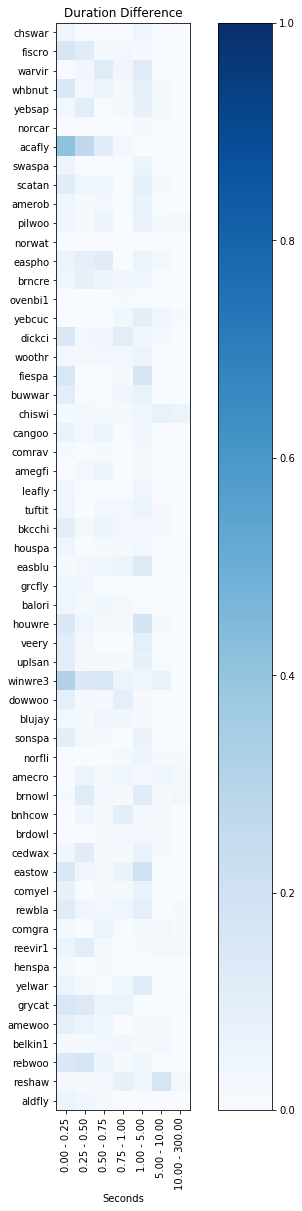

In [45]:
# Histogram of box durations per species

per_species_box_durations = {'train' : {}, 'test' : {}}
for target_code, target_annos in annotation_df.groupby(['category_id']):
    if target_code in annotated_target_categories:
        
        per_species_box_durations['train'][target_code] = []
        per_species_box_durations['test'][target_code] = []
        
        for i, anno in target_annos.iterrows():
            box_start_sec = anno['box_start_sec']
            box_stop_sec = anno['box_end_sec']

            if anno['asset_id'] in train_asset_ids:
                per_species_box_durations['train'][target_code].append(box_stop_sec - box_start_sec)
            else:
                per_species_box_durations['test'][target_code].append(box_stop_sec - box_start_sec)

bin_edges = [0, 0.25, 0.5, 0.75, 1, 5, 10, 300]
x_train = []
x_test = []
y = []
for target_code in annotated_target_categories:
    
    train_box_durs = per_species_box_durations['train'][target_code]
    test_box_durs = per_species_box_durations['test'][target_code]
    
    h_train = np.histogram(train_box_durs, bin_edges)[0]
    h_train = h_train / h_train.sum()
    h_test = np.histogram(test_box_durs, bin_edges)[0]
    h_test = h_test / h_test.sum()
    
    x_train.append(h_train)
    x_test.append(h_test)
    y.append(target_code)

x_train = np.array(x_train)
x_test = np.array(x_test)
    
cmap = plt.get_cmap('Blues')



plt.figure(figsize=(10,20))
plt.subplot(1, 2, 1)

plt.imshow(x_train, interpolation=None, cmap=cmap, vmin=0, vmax=1.0)#vmax=np.max(x_train))
#plt.colorbar()

y_tick_marks = np.arange(len(x_train))
plt.yticks(y_tick_marks, y)
plt.ylim([y_tick_marks[-1]+0.5,y_tick_marks[0]-0.5 ])

x_tick_marks = np.arange(len(bin_edges) - 1)
x_tick_names = ["%0.2f - %0.2f" % (bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges) - 1)]
plt.xticks(x_tick_marks, x_tick_names, rotation=90)
plt.xlabel("Seconds")
plt.title("Train Set Durations")


plt.subplot(1, 2, 2)

plt.imshow(x_test, interpolation=None, cmap=cmap, vmin=0, vmax=1.0)#np.max(x_train))
plt.colorbar()

y_tick_marks = np.arange(len(x_train))
plt.yticks(y_tick_marks, y)
plt.ylim([y_tick_marks[-1]+0.5,y_tick_marks[0]-0.5 ])

x_tick_marks = np.arange(len(bin_edges) - 1)
x_tick_names = ["%0.2f - %0.2f" % (bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges) - 1)]
plt.xticks(x_tick_marks, x_tick_names, rotation=90)
plt.xlabel("Seconds")
plt.title("Test Set Durations")



# Show the absolute difference between the two distributions 

plt.figure(figsize=(10,20))
plt.subplot(1, 1, 1)
plt.imshow(np.abs(x_train - x_test), interpolation=None, cmap=cmap, vmin=0, vmax=1.0)
plt.colorbar()

y_tick_marks = np.arange(len(x_train))
plt.yticks(y_tick_marks, y)
plt.ylim([y_tick_marks[-1]+0.5,y_tick_marks[0]-0.5 ])

x_tick_marks = np.arange(len(bin_edges) - 1)
x_tick_names = ["%0.2f - %0.2f" % (bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges) - 1)]
plt.xticks(x_tick_marks, x_tick_names, rotation=90)
plt.xlabel("Seconds")
plt.title("Duration Difference")

In [26]:
# Print out box counts for each species

i=0
print("   \t%10s\t%10s\t%10s\t%10s\t%10s" % ("species", "train asts", "train box", "test asts", "test box"))
for category_id in category_order:
    
    category_annos = annotation_df[annotation_df['category_id'] == category_id]
    
    primary_annos = category_annos[category_annos['is_primary']]
    
    train_annos = primary_annos[primary_annos['split'] == 'train']    
    num_train_assets = train_annos['asset_id'].unique().shape[0]
    num_train_boxes = train_annos.shape[0]
    
    test_annos = primary_annos[primary_annos['split'] == 'test']
    num_test_assets = test_annos['asset_id'].unique().shape[0]
    num_test_boxes = test_annos.shape[0]
    
    print("%3d\t%10s\t%10d\t%10d\t%10d\t%10d" % (i+1, category_id, num_train_assets, num_train_boxes, num_test_assets, num_test_boxes))
    i += 1

   	   species	train asts	 train box	 test asts	  test box
  1	    cangoo	        52	       315	        31	       197
  2	    yebcuc	        46	       155	        33	        76
  3	    chiswi	        59	       226	        36	       104
  4	    uplsan	        64	       223	        37	        94
  5	    amewoo	        61	       400	        39	       246
  6	    reshaw	        62	       117	        36	        54
  7	    brnowl	        60	       340	        40	       176
  8	    brdowl	        64	       266	        35	       109
  9	   belkin1	        64	       284	        35	       160
 10	    yebsap	        59	       275	        38	       146
 11	    rebwoo	        59	       283	        37	       187
 12	    dowwoo	        59	       418	        36	       193
 13	    pilwoo	        48	        84	        24	        51
 14	    norfli	        55	       190	        32	       162
 15	    acafly	        60	       306	        39	       134
 16	    aldfly	        63	       412	        39	       2

In [ ]:
# Go through and create the tfrecords

# The idea here is that we will crop out multiple sections of each audio clip where a section is centered on a target box. 
# Some things to keep in mind are:
#   How long should a section be? 

In [27]:
def _int64_feature(value):
    """Wrapper for inserting int64 features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    """Wrapper for inserting float features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _validate_text(text):
    """Convert text to string and then bytes."""

    if isinstance(text, str):
        return text.encode('utf-8', 'ignore')
    else:
        return str(text).encode('utf-8', 'ignore')

In [28]:
# Configurations for storing the audio in the tfrecords

SAMPLE_RATE = 44100
MIN_DURATION_SEC = 3.0
MAX_FREQ = 12000
MIN_OVERLAPPING_BOX_DUR_SEC = 0.01
MIN_BOX_DUR_SEC = 0.01

NUM_CLIPS_PER_TFRECORD = 1000

MULTILABEL_SETUP = True
CREATE_WINDOWS_AROUND_NON_TARGETS = False

In [49]:
# Directory to write data
tfrecord_dataset_dir = '/data/datasets/ebyb_audio/v9/'

# Clear out previous contents?
if True:
    if os.path.exists(tfrecord_dataset_dir):
        shutil.rmtree(tfrecord_dataset_dir)
    os.makedirs(tfrecord_dataset_dir)

tfrecord_dir = os.path.join(tfrecord_dataset_dir, 'tfrecords')
if not os.path.exists(tfrecord_dir):
    os.makedirs(tfrecord_dir)
    
# Save off the category map
with open(os.path.join(tfrecord_dataset_dir, 'labels.json'), 'w') as f:
    json.dump(category_order, f)

# Save off the pandas annotation data frame
annotation_df.to_csv(os.path.join(tfrecord_dataset_dir, 'annotations_df.csv'))

In [50]:
# Create the tfrecord examples

for split, split_annotations_df in annotation_df.groupby(['split']):
    
    tfrecord_prefix = split
    
    print("Working on %s split" % (tfrecord_prefix,))
    
    total_clips = 0
    total_duration = 0.
    
    record_index = 0
    output_filename = '%s-%.5d' % (tfrecord_prefix, record_index)
    output_fp = os.path.join(tfrecord_dir, output_filename)
    writer = tf.io.TFRecordWriter(output_fp)
    tfrecord_clip_count = 0
    
    # Group the boxes by asset_id
    
    for asset_id, asset_boxes_df in split_annotations_df.groupby(['asset_id']):

        # Load in the waveform
        audio_fn = "%d.mp3" % (asset_id,)
        asset_fp = os.path.join(mp3_dir, audio_fn)
        assert os.path.exists(asset_fp), "Audio not available"
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                samples, samplerate = librosa.load(asset_fp, sr=None, mono=True)
        except:
            print("ERROR: could not load audio at %s" % asset_fp)
            continue
            
        asset_duration_secs = float(samples.shape[0]) / samplerate
        
        # Append 0s if the entire clip is super short
        if asset_duration_secs < MIN_DURATION_SEC:
            p = int(MIN_DURATION_SEC * samplerate) - samples.shape[0]
            samples = np.concatenate([samples, np.zeros([p], dtype=samples.dtype)])
            asset_duration_secs = float(samples.shape[0]) / samplerate
            print("Padding asset %d" % (asset_id,))
        
        
        # Grab the boxes & labels
        boxes = asset_boxes_df[['box_low_freq', 'box_start_sec', 'box_high_freq', 'box_end_sec']].to_numpy()
        labels = asset_boxes_df['category_id'].tolist()
        is_primary = asset_boxes_df['is_primary'].tolist()

        # Go through each box and create a window centered around it
        for target_idx in range(len(labels)):

            target_box = boxes[target_idx]
            target_label = labels[target_idx]
            target_is_primary = is_primary[target_idx]
            
            # Are we creating windows around the non-target species for this asset? 
            if not CREATE_WINDOWS_AROUND_NON_TARGETS and not target_is_primary:
                continue

            # Create a window around the target box
            target_box_start_sec = target_box[1]
            target_box_end_sec = target_box[3]
            
            # Make sure the box is within the audio bounds
            target_box_start_sec = np.clip(target_box_start_sec, 0, asset_duration_secs)
            target_box_end_sec = np.clip(target_box_end_sec, 0, asset_duration_secs)
            if not target_box_start_sec < target_box_end_sec:
                print()
                print("WARNING: Found a bad box for asset %d" % asset_id)
                print("After clipping to the audio duration, the start of the box %0.4f is not less than the end of the box %0.4f" % (target_box_start_sec, target_box_end_sec))
                print()
                continue

            #assert target_box_start_sec < target_box_end_sec, "This shouldn't be the case..."
            target_dur = target_box_end_sec - target_box_start_sec

            if target_dur < MIN_BOX_DUR_SEC:
                print("Found really short box (%0.4f) for asset %d" % (box_duration, asset_id,))
                continue

            # Add padding around the box
            if target_dur < MIN_DURATION_SEC:

                p = (MIN_DURATION_SEC - target_dur) / 2.0 

                if target_box_start_sec - p < 0:
                    # move the extra padding to the end

                    window_start_sec = 0

                    xp = np.abs(target_box_start_sec - p)
                    ep = p + xp
                    if target_box_end_sec + ep > asset_duration_secs and not np.isclose(target_box_end_sec + ep, asset_duration_secs):
                        print("Total asset duration is less than MIN_DURATION_SEC")
                        print(asset_id)
                        print()
                        #continue
                        
                        assert False, "we shouldn't be here since we appended 0s"
                        
                    else:
                        window_end_sec = min(target_box_end_sec + ep, asset_duration_secs)
                else:

                    if target_box_end_sec + p > asset_duration_secs:
                        # Move the extra padding to the beginning

                        window_end_sec = asset_duration_secs

                        xp = np.abs(asset_duration_secs - (target_box_end_sec + p))
                        ep = p + xp
                        if target_box_start_sec - ep < 0 and not np.isclose(target_box_start_sec - ep, 0):
                            print("Total asset duration is less than MIN_DURATION_SEC")
                            print(asset_id)
                            print()
                            #continue
                            
                            assert False, "we shouldn't be here since we appended 0s"
                            
                        else:
                            window_start_sec = max(0, target_box_start_sec - ep)

                    else:
                        window_start_sec = max(0, target_box_start_sec - p)
                        window_end_sec = min(target_box_end_sec + p, asset_duration_secs)

                if not np.isclose(window_end_sec - window_start_sec, MIN_DURATION_SEC):
                    print("Logic error when padding")
                    print(asset_id)
                    print()
                    assert False

            else:
                window_start_sec = target_box_start_sec
                window_end_sec = target_box_end_sec


            window_dur_sec = window_end_sec - window_start_sec
            assert np.isclose(window_dur_sec, MIN_DURATION_SEC) or window_dur_sec > MIN_DURATION_SEC, "Why is the window duration less than MIN_DURATION_SEC?"


            # Do any of the other boxes overlap with this window? 

            other_boxes = [boxes[j] for j in range(len(labels)) if j != target_idx]
            other_indices = [j for j in range(len(labels)) if j != target_idx]
            #other_labels = [labels[j] for j in range(len(labels)) if j != target_idx]
            if MULTILABEL_SETUP and len(other_boxes) > 0:

                bl = box_list.BoxList(tf.constant(other_boxes, dtype=tf.float32))
                bl.add_field("index", tf.constant(other_indices, dtype=tf.float32))

                window_box = tf.constant([0, window_start_sec, MAX_FREQ, window_end_sec])

                overlapping_boxes = box_list_ops.clip_to_window(bl, window_box, filter_nonoverlapping=True)
                overlapping_boxes = box_list_ops.prune_small_boxes(overlapping_boxes, min_side=MIN_OVERLAPPING_BOX_DUR_SEC)

                additional_boxes = overlapping_boxes.get().numpy().tolist()
                additional_indices = [int(l) for l in overlapping_boxes.get_field("index").numpy().tolist()]
                additional_labels = [labels[j] for j in additional_indices]
                assert target_idx not in additional_labels, "something is wrong, the target index should not have been an `other`"
                
                #if len(additional_boxes) > 0:
                #    print("Found %d overlapping boxes for asset %d" % (len(additional_boxes), asset_id))

                total_boxes = [target_box] + additional_boxes
                total_labels = [target_label] + additional_labels

            else:
                total_boxes = [target_box]
                total_labels = [target_label]


            # Create a tfrecord with the waveform, boxes, and labels

            window_start_samples = int(round(window_start_sec * samplerate))
            window_end_samples = int(round(window_end_sec * samplerate))


            assert window_start_samples >= 0, "Why is window_start_samples negative?"
            assert window_end_samples <= samples.shape[0], "Why is window_end_samples past the end of the audio clip?"

            window_waveform = samples[window_start_samples:window_end_samples]
            if samplerate != SAMPLE_RATE:
                window_samples = resampy.resample(window_waveform, samplerate, SAMPLE_RATE)
                window_samplerate = SAMPLE_RATE
            else:
                window_samples = window_waveform
                window_samplerate = SAMPLE_RATE

            # Create the arrays to store in the tfrecord. 

            box_start_sec = []
            box_end_sec = []
            box_high_freq = []
            box_low_freq = []
            box_label = []
            box_text = []
            box_background = []
            box_certain = []

            for i in range(len(total_labels)):

                freq_low, start_sec, freq_high, stop_sec = total_boxes[i]
                category_label = total_labels[i]

                box_start_sec.append(start_sec - window_start_sec)
                box_end_sec.append(stop_sec - window_start_sec)
                box_high_freq.append(freq_high)
                box_low_freq.append(freq_low)
                box_label.append(category_id_to_int_label[category_label])
                box_text.append(str(category_label))
                box_background.append(0)
                box_certain.append(1)

            
            example = tf.train.Example(features=tf.train.Features(feature={

                'audio/waveform': _float_feature(window_samples.ravel().tolist()),
                'audio/samplerate' : _int64_feature(window_samplerate),
                'audio/filename' : _bytes_feature(_validate_text(audio_fn)),
                'audio/start_offset_secs' : _float_feature(window_start_sec),
                'audio/end_offset_secs' : _float_feature(window_end_sec),
                'audio/duration_secs' : _float_feature(window_dur_sec),

                'audio/object/bbox/start_sec': _float_feature(box_start_sec),
                'audio/object/bbox/end_sec': _float_feature(box_end_sec),
                'audio/object/bbox/high_freq': _float_feature(box_high_freq),
                'audio/object/bbox/low_freq': _float_feature(box_low_freq),

                'audio/object/class/label': _int64_feature(box_label),
                'audio/object/class/text': _bytes_feature(list(map(_validate_text, box_text))),
                'audio/object/class/background': _int64_feature(box_background),
                'audio/object/class/certain': _int64_feature(box_certain)

            }))

            writer.write(example.SerializeToString())
            tfrecord_clip_count += 1
            total_clips += 1
            total_duration += window_dur_sec
            
            if tfrecord_clip_count >= NUM_CLIPS_PER_TFRECORD:
                writer.close()
                print("Wrote %d clips to %s" % (tfrecord_clip_count, output_fp))
                
                record_index += 1
                output_filename = '%s-%.5d' % (tfrecord_prefix, record_index)
                output_fp = os.path.join(tfrecord_dir, output_filename)
                writer = tf.io.TFRecordWriter(output_fp)
                tfrecord_clip_count = 0
    
    
    if tfrecord_clip_count > 0:
        writer.close()
        print("Wrote %d clips to %s" % (tfrecord_clip_count, output_fp))
        
    print("Finished split %s, wrote a total of %d clips" % (tfrecord_prefix, total_clips))  
    print("Total clip duration: %0.5f" % (total_duration,))
    print()

Working on test split
Padding asset 141113311
Padding asset 142111011
Padding asset 145710291
Padding asset 147445851
Wrote 1000 clips to /data/datasets/ebyb_audio/v9/tfrecords/test-00000
Padding asset 159378811
Padding asset 162073161
Padding asset 162360931
Padding asset 162820111
Wrote 1000 clips to /data/datasets/ebyb_audio/v9/tfrecords/test-00001
Padding asset 166374971
Padding asset 167517031
Padding asset 167756691
Padding asset 168887251
Padding asset 169081011
Wrote 1000 clips to /data/datasets/ebyb_audio/v9/tfrecords/test-00002
Padding asset 170661341
Padding asset 173535911
Padding asset 174233341
Padding asset 174518021
Padding asset 174518031
Wrote 1000 clips to /data/datasets/ebyb_audio/v9/tfrecords/test-00003
Padding asset 175054751
Padding asset 175829491
Padding asset 175837891
Padding asset 176628471
Padding asset 176629521
Padding asset 176630531
Padding asset 177712241
Padding asset 178968981
Padding asset 179178191
Wrote 1000 clips to /data/datasets/ebyb_audio/v9/t

In [5]:
# Visualize some of the data that we just generated

#sys.path.append("/home/gvanhorn/code/research/merlin_ai/vision/audio_classification")
import dataset_processing
import params

In [51]:
with open('/data/datasets/ebyb_audio/v9/labels.json') as f:
    label_names = json.load(f)

In [6]:
# Make any changes to params
params.SAMPLE_RATE = 44100

num_classes = 57 #len(category_order)
min_box_length_secs = 0.01
min_duration_secs = 1.0

tfrecord_file_pattern = ["/data/datasets/ebyb_audio/v9/tfrecords/train*"]

In [143]:


input_fnc = dataset_processing.parse_audio_function(
    num_classes=num_classes,
    min_box_length_secs=min_box_length_secs,
    do_random_crop=True,
    add_gaussian_noise=True,
    min_duration_secs=min_duration_secs, 
    filter_empty_patches=True, 
    normalize_labels=True
)

dataset = dataset_processing.build_dataset(
    tfrecord_file_pattern=tfrecord_file_pattern,
    input_parse_fn=input_fnc,
    prefetch_batch_size=32,
    is_training=True,
    num_parallel_reads=5
)
dataset = dataset.unbatch()
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.as_numpy_iterator()


Text(0.5, 1.0, 'sonspa')

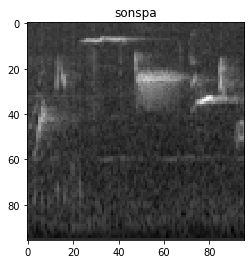

In [181]:
image, labels = next(dataset)

spec_input = rotate(image, 90) 
plt.figure()
plt.imshow(spec_input, cmap='gray_r')

title_string = []
for l in np.where(labels > 0)[0]:
    title_string.append(label_names[l])
title = ", ".join(title_string)
plt.title(title)

In [128]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [42]:
image.shape

(96, 96, 3)

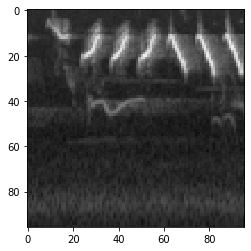